# Pneumonia Classification

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [6]:
import numpy as np 
import pandas as pd 
import os

In [7]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [8]:
train = get_training_data('X-Ray/train')
test = get_training_data('X-Ray/test')
val = get_training_data('X-Ray/val')

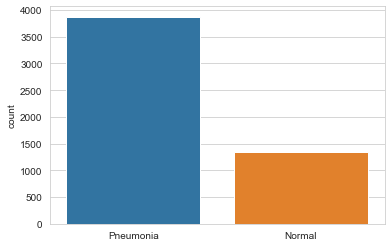

In [9]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style("whitegrid")
sns.countplot(l)

The data is imbalanced. To increase the of training examples, we will use data augmentation

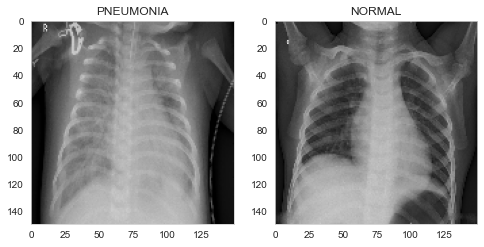

In [76]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(8,8)

ax[0].imshow(train[0][0], cmap='gray')
ax[0].set_title(labels[train[0][1]])
ax[0].grid(None) 

ax[1].imshow(train[-1][0], cmap='gray')
ax[1].set_title(labels[train[-1][1]])
ax[1].grid(None) 

In [20]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [21]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [23]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

### Data Augmentation

Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model. It is closely related to oversampling in data analysis.

Geometric transformations, flipping, color modification, cropping, rotation, noise injection and random erasing are used to augment image in deep learning

For the data augmentation we will:

Randomly rotate some training images by 30 degrees  
Randomly Zoom by 20% some training images  
Randomly shift images horizontally by 10% of the width  
Randomly shift images vertically by 10% of the height  
Randomly flip images horizontally.   


In [73]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

Defining the CNN model:

In [26]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))

In [27]:
model.compile(optimizer = "rmsprop" , 
              loss = 'binary_crossentropy' , 
              metrics = ['accuracy'])

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001)

In [29]:
cnn = model.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 10, 
                    validation_data = datagen.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 388s 2s/step - loss: 0.5538 - accuracy: 0.8411 - val_loss: 34.9530 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 419s 3s/step - loss: 0.2660 - accuracy: 0.8999 - val_loss: 145.4245 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9153
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 335s 2s/step - loss: 0.2311 - accuracy: 0.9153 - val_loss: 114.0660 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 310s 2s/step - loss: 0.1417 - accuracy: 0.9496 - val_loss: 26.3550 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 310s 2s/step - loss: 0.1472 - accuracy: 0.9523 - val_loss: 0.5836 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 428s 3s/step - loss: 0.1314 - accuracy: 0.9534 - val_loss: 1

In [30]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 6s 280ms/step - loss: 0.2895 - accuracy: 0.9199
Loss of the model is -  0.2895248532295227
20/20 [==============================] - 6s 281ms/step - loss: 0.2895 - accuracy: 0.9199
Accuracy of the model is -  91.98718070983887 %


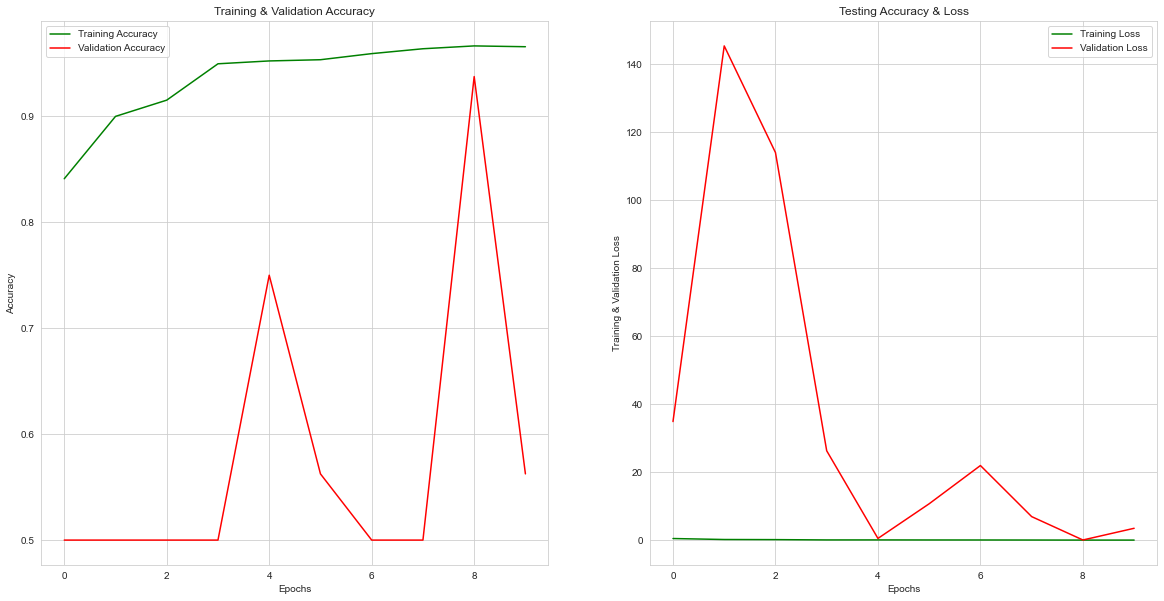

In [35]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = cnn.history['accuracy']
train_loss = cnn.history['loss']
val_acc = cnn.history['val_accuracy']
val_loss = cnn.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'g-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [36]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, 
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.96      0.94       390
   Normal (Class 1)       0.92      0.86      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



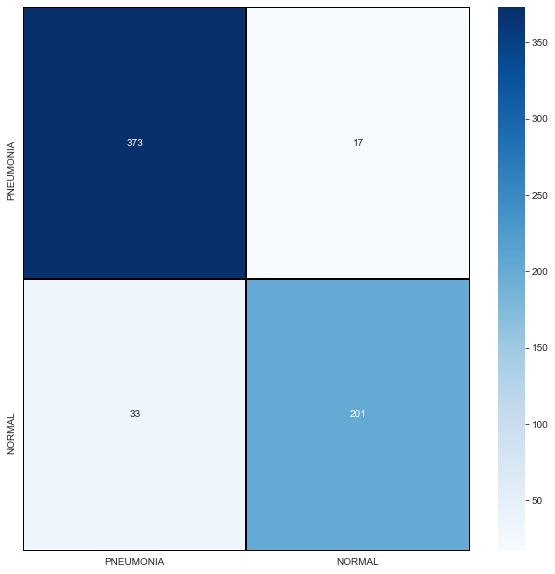

In [37]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , 
            annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [38]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

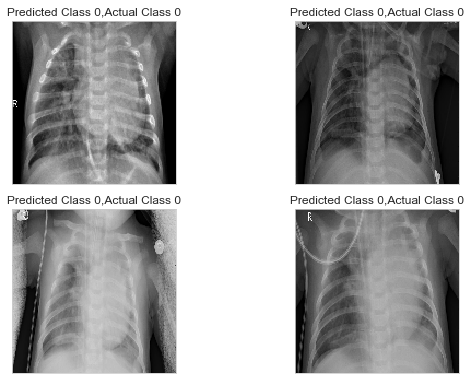

In [71]:
plt.figure(figsize = (8,8))
i = 0
for c in correct[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

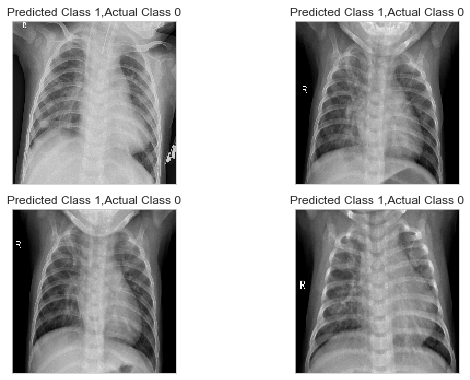

In [72]:
plt.figure(figsize = (8,8))
i = 0
for c in incorrect[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1